# User Adoption Prediction

## 1. Import

In [65]:
import pandas as pd
import urllib
import json
import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## 2. Load the data

In [66]:
users = pd.read_csv(r'C:\Users\JIYOON JUNG\Desktop\Springboard\Unit 34 Effective Interviewing\1481069814_relax_challenge\relax_challenge\takehome_users.csv', encoding='ISO-8859-1')
engagement = pd.read_csv(r'C:\Users\JIYOON JUNG\Desktop\Springboard\Unit 34 Effective Interviewing\1481069814_relax_challenge\relax_challenge\takehome_user_engagement.csv', encoding='ISO-8859-1')

## 3. Explore the data

In [67]:
print(users.shape)
print(engagement.shape)

(12000, 10)
(207917, 3)


### 3.1 users dataset

In [68]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [69]:
users.info() #last_session_creation_time has some null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [70]:
users['object_id'].nunique() #  'user' dataset has no duplicate user information

12000

In [71]:
users['last_session_creation_time'].value_counts()

1.401868e+09    2
1.401917e+09    2
1.398139e+09    1
1.381812e+09    1
1.400737e+09    1
               ..
1.393803e+09    1
1.343116e+09    1
1.382131e+09    1
1.373158e+09    1
1.390727e+09    1
Name: last_session_creation_time, Length: 8821, dtype: int64

In [72]:
users['creation_time'] = pd.to_datetime(users['creation_time'], format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

C:\Users\JIYOON JUNG\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:530: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


In [73]:
creation_time_min = users['creation_time'].min()
creation_time_max = users['creation_time'].max()

last_session_min = users['last_session_creation_time'].min()
last_session_max = users['last_session_creation_time'].max()

print(f"Creation Time range: {creation_time_min} to {creation_time_max}") 
print(f"Last Session Creation Time range: {last_session_min} to {last_session_max}")

Creation Time range: 2012-05-31 00:43:27 to 2014-05-30 23:59:19
Last Session Creation Time range: 2012-05-31 08:20:06 to 2014-06-06 14:58:50


### 3.2 engagement dataset

In [74]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [75]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [76]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S')

In [77]:
engagement_time_min = engagement['time_stamp'].min()
engagement_time_max = engagement['time_stamp'].max()

print(f"Engagement Time range: {engagement_time_min} to {engagement_time_max}") 

Engagement Time range: 2012-05-31 08:20:06 to 2014-06-06 14:58:50


In [78]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


## 4. Define the 'adopted user'

In [79]:
# Ensure the DataFrame is sorted by 'user_id' and 'time_stamp' for correct rolling application.
engagement = engagement.sort_values(['user_id', 'time_stamp'])

# Define a function that applies a rolling window to count visits within a 7-day period.
def check_visits(group):
    # The rolling count is applied on the 'time_stamp' after temporarily setting it as the index.
    # 'closed' is set to 'right' to include the current row in the count.
    rolling_count = group.set_index('time_stamp').rolling('7D', closed='right').count()
    # Returns a Series indicating whether each row in the group has a rolling count of 3 or more.
    return rolling_count['visited'] >= 3

# Apply the function to each user group. The result is a Series with a MultiIndex (user_id, original index).
has_3_visits_in_7_days = engagement.groupby('user_id', group_keys=False).apply(check_visits)

# Add the result back to the original DataFrame.
engagement['has_3_visits_in_7_days'] = has_3_visits_in_7_days.values

In [80]:
adopted_user = pd.DataFrame(engagement[engagement['has_3_visits_in_7_days'] == True]['user_id'].unique())

In [83]:
adopted_user.columns = ['object_id']
adopted_user['adopted'] = "Y"
adopted_user.head()

,object_id,adopted
0,2,Y
1,10,Y
2,20,Y
3,33,Y
4,42,Y


In [88]:
users_dtl = pd.merge(users, adopted_user, how = 'left', on = 'object_id')
users_dtl['adopted'] = users_dtl['adopted'].fillna('N')
print(users_dtl.shape)
users_dtl.head()

(12000, 11)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,N
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,Y
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,N
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,N
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,N


## 5. Check what featuers affect the determination of "adopted user".

In [89]:
users_dtl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     12000 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)


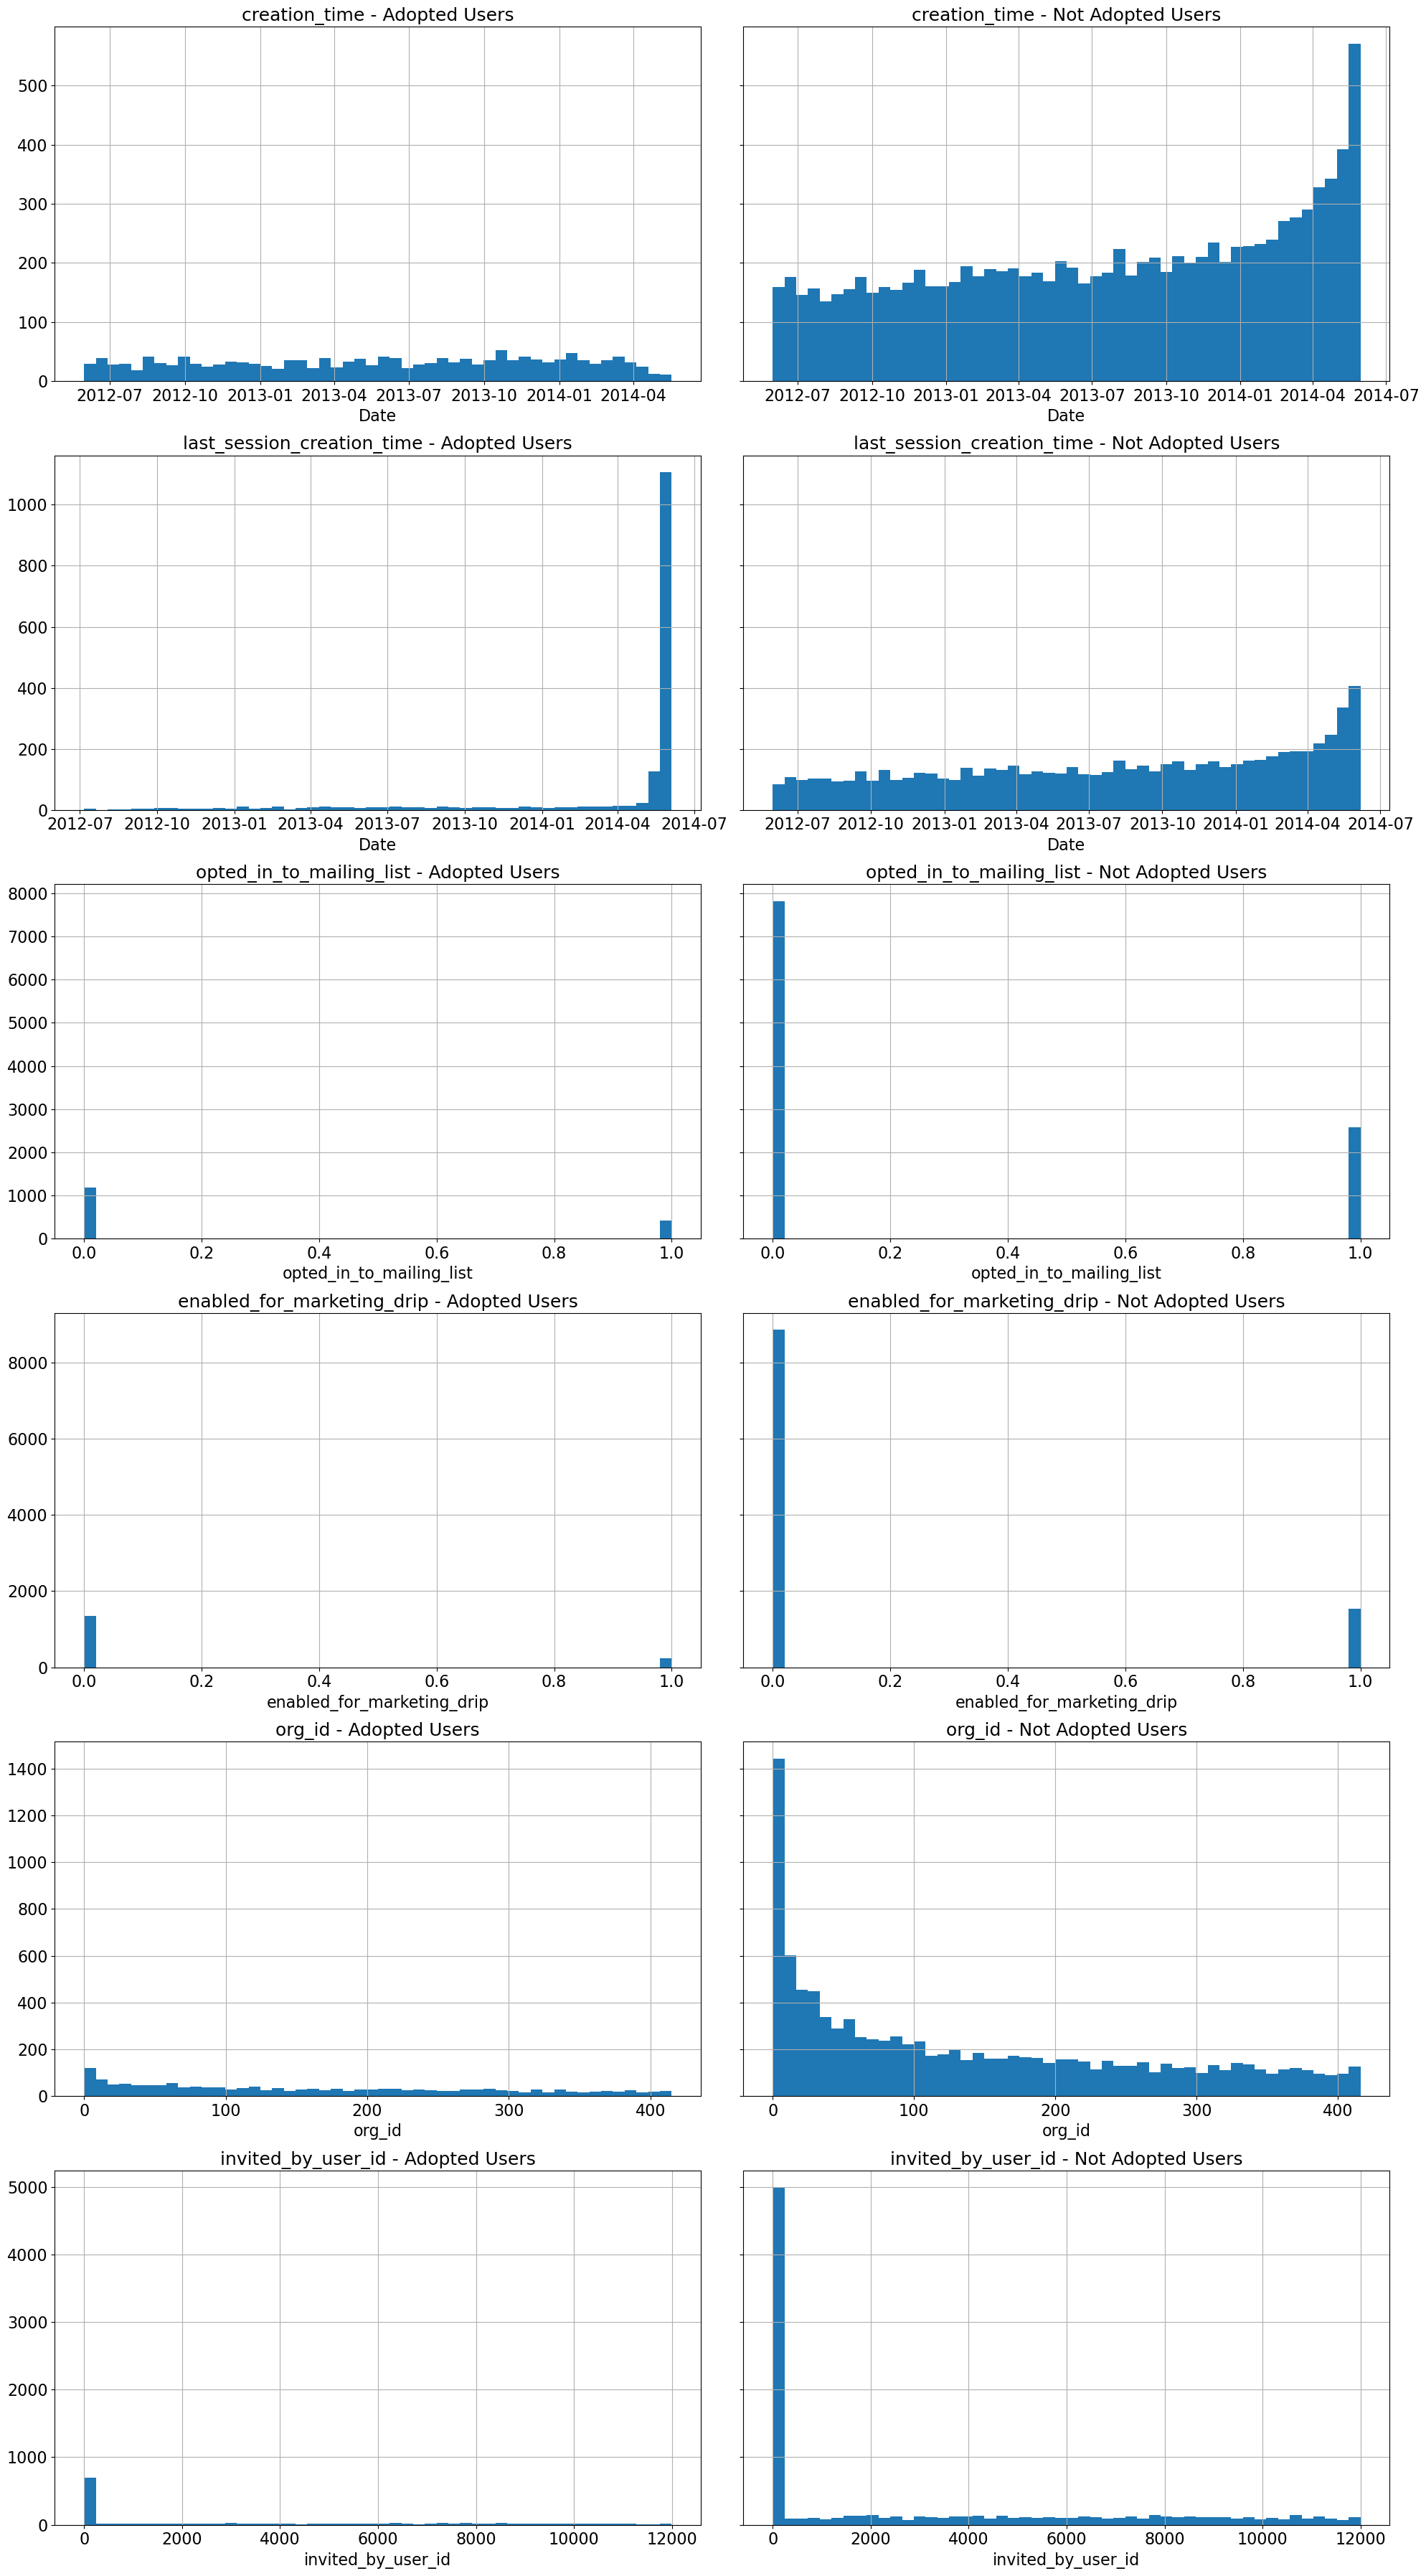

In [94]:
# Split the DataFrame based on 'adopted' status
adopted_users = users_dtl[users_dtl['adopted'] == 'Y']
not_adopted_users = users_dtl[users_dtl['adopted'] == 'N']

# List of columns to plot
columns_to_plot = ['creation_time', 'last_session_creation_time', 
                   'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 
                   'org_id', 'invited_by_user_id']

# Prepare the figure with a flexible layout
fig, axes = plt.subplots(len(columns_to_plot), 2, figsize=(20, 6 * len(columns_to_plot)), sharey='row')

# Titles for the columns
titles = ['Adopted Users', 'Not Adopted Users']

for i, column in enumerate(columns_to_plot):
    for j, (group, title) in enumerate(zip([adopted_users, not_adopted_users], titles)):
        ax = axes[i, j]
        if users_dtl[column].dtype == 'datetime64[ns]':
            group[column].dt.date.hist(ax=ax, bins=50)
            ax.set_title(f"{column} - {title}", fontsize=18)
            ax.set_xlabel('Date', fontsize=16) 
        elif column == 'invited_by_user_id':
            group[column].fillna(-1).hist(ax=ax, bins=50)
            ax.set_title(f"{column} - {title}", fontsize=18) 
            ax.set_xlabel(column, fontsize=16)  
        else:
            group[column].hist(ax=ax, bins=50)
            ax.set_title(f"{column} - {title}", fontsize=18)  
            ax.set_xlabel(column, fontsize=16)  
        
        # Optionally, increase tick label size
        ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()
plt.show()

### 5.1 Data Processing

In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Convert 'adopted' to numeric (Y=1, N=0)
users_dtl['adopted'] = users_dtl['adopted'].map({'Y': 1, 'N': 0})

# Convert 'creation_time' and 'last_session_creation_time' to a more usable form, e.g., duration
users_dtl['account_age_days'] = (users_dtl['last_session_creation_time'] - users_dtl['creation_time']).dt.days
users_dtl['account_age_days'] = users_dtl['account_age_days'].fillna(0)

# Convert categorical columns to numeric using Label Encoding
label_encoders = {}
for column in ['creation_source']:
    le = LabelEncoder()
    users_dtl[column] = le.fit_transform(users_dtl[column])
    label_encoders[column] = le

# Handle missing values for 'invited_by_user_id'
users_dtl['invited_by_user_id'] = users_dtl['invited_by_user_id'].fillna(-1)

# Define features and target
X = users_dtl[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'account_age_days']]
y = users_dtl['adopted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 5.2 Train a Random Forest Classifier

In [96]:
# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 5.3 Evaluate Feature Importance

In [97]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {X_train.columns[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. feature account_age_days (0.8762414823528458)
2. feature org_id (0.06618979292356472)
3. feature invited_by_user_id (0.03662518844284245)
4. feature creation_source (0.012586721019502308)
5. feature opted_in_to_mailing_list (0.004599670847749979)
6. feature enabled_for_marketing_drip (0.003757144413494724)
